In [7]:
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import misc
from scipy import stats
import pickle
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, r2_score, mean_squared_error, mean_absolute_error

In [8]:
repo = os.path.join('/home/sditom/us_crop_type_hindcast/public')
fig_repo = os.path.join(repo,'figs')

In [9]:
# This script is to compare csdl-cdl- with NASS corn soy area over time

In [10]:
# cd us_hindecast_project/public/data
# gsutil cp -r gs://us_crop_type_hindcast/cdl13states_allclasses .
# gsutil cp -r gs://us_crop_type_hindcast/extendedCDL_v3_NLCDmasked .

## Load Dataset

### NASS

In [11]:
## download nass 13 states using Rcode on my computer: 1999-2018 corn and soy

In [12]:
nass_corn = pd.read_csv(os.path.join(repo,'data','nass','areaPlanted','NASS_cropAreaCorn_1999to2018_raw.csv'))
nass_soy = pd.read_csv(os.path.join(repo,'data','nass','areaPlanted','NASS_cropAreaSoy_1999to2018_raw.csv'))

cols = ['state_fips_code','county_code','year','state_alpha','class_desc','short_desc','statisticcat_desc','commodity_desc','util_practice_desc','Value']
nass_soy = nass_soy[cols]
nass_corn = nass_corn[cols]

In [13]:
# print(nass_corn.shape)
# nass_corn.head()

In [14]:
# print(nass_soy.shape)
# nass_soy.head()

In [15]:
nass = pd.concat([nass_corn, nass_soy])
print(nass.shape)
nass.head()

(39986, 10)


,state_fips_code,county_code,year,state_alpha,class_desc,short_desc,statisticcat_desc,commodity_desc,util_practice_desc,Value
0,18,7,2018,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"120,000"
1,18,7,2017,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"123,000"
2,18,7,2016,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"125,000"
3,18,7,2015,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"129,000"
4,18,7,2014,IN,ALL CLASSES,CORN - ACRES PLANTED,AREA PLANTED,CORN,ALL UTILIZATION PRACTICES,"130,000"


In [16]:
# Create a unique county-identifier: stateFIPS+countyFIPS
nass['county_code'] = nass['county_code'].map(int).apply(lambda x: '{0:0>3}'.format(x))# to make fixlenght=3
nass['state_fips_code'] = nass['state_fips_code'].apply(lambda x: '{0:0>2}'.format(x))# to make fixlenght=2
nass['fips'] = (nass['state_fips_code'].map(str)+nass['county_code'].map(str)).map(int)

nass['commodity_desc'] = nass['commodity_desc'].str.title()
nass = nass.rename(columns={"commodity_desc":"crop", "state_alpha":"state", "Value":"Nass_Area_acres"})
nass['Nass_Area_acres'] = nass['Nass_Area_acres'].str.replace(',', '').astype('float')
nass["Nass_Area_m2"] = nass["Nass_Area_acres"]*4046.86
nass = nass[['fips', 'year', 'state', 'crop', "Nass_Area_m2"]]
nass.head()

,fips,year,state,crop,Nass_Area_m2
0,18007,2018,IN,Corn,485623200.0
1,18007,2017,IN,Corn,497763780.0
2,18007,2016,IN,Corn,505857500.0
3,18007,2015,IN,Corn,522044940.0
4,18007,2014,IN,Corn,526091800.0


In [17]:
# nass.to_csv(os.path.join(repo,'data','nass','NASS_CropArea_13States_1999-2018_cropAggregates_areaPlanted.csv'),index=False)# (2201664, 27)

### CDL

In [18]:
cdl_dir = os.path.join(repo,'data','cdl13states_allclasses')

cdl = pd.DataFrame()
for filename in os.listdir(cdl_dir):
    if (filename.endswith('.csv')):
        print(filename)
        temp = pd.read_csv(os.path.join(cdl_dir, filename)).drop(['.geo','system:index'],axis=1)
        cdl = pd.concat([temp, cdl], sort=True)
cdl = cdl[cdl['masterid']!=0]# drop dummy feature     

2011_CDL_13States_allclasses_area_m2.csv
2003_CDL_13States_allclasses_area_m2.csv
2010_CDL_13States_allclasses_area_m2.csv
2009_CDL_13States_allclasses_area_m2.csv
2014_CDL_13States_allclasses_area_m2.csv
2008_CDL_13States_allclasses_area_m2.csv
2005_CDL_13States_allclasses_area_m2.csv
2017_CDL_13States_allclasses_area_m2.csv
2012_CDL_13States_allclasses_area_m2.csv
2000_CDL_13States_allclasses_area_m2.csv
2007_CDL_13States_allclasses_area_m2.csv
1999_CDL_13States_allclasses_area_m2.csv
2013_CDL_13States_allclasses_area_m2.csv
2002_CDL_13States_allclasses_area_m2.csv
2018_CDL_13States_allclasses_area_m2.csv
2006_CDL_13States_allclasses_area_m2.csv
2001_CDL_13States_allclasses_area_m2.csv
2016_CDL_13States_allclasses_area_m2.csv
2004_CDL_13States_allclasses_area_m2.csv
2015_CDL_13States_allclasses_area_m2.csv


In [19]:
print(cdl.shape)
cdl.head()

(23500, 141)


,0,1,10,11,111,112,12,121,122,123,...,82,83,87,88,92,COUNTYFP,STATEFP,Year,area_m2,masterid
1,NaN,3.354098e+07,NaN,NaN,6.878912e+07,NaN,NaN,6.316608e+07,3.131050e+07,4.706327e+06,...,NaN,NaN,NaN,NaN,NaN,141,26,2015,6.647720e+09,26141
2,NaN,3.422329e+07,NaN,NaN,5.592288e+07,NaN,NaN,5.927261e+07,3.455770e+07,1.112628e+07,...,NaN,NaN,NaN,NaN,NaN,7,26,2015,4.380054e+09,26007
3,NaN,1.872025e+07,NaN,NaN,5.442769e+07,NaN,NaN,8.151642e+07,1.914550e+07,2.011239e+06,...,NaN,NaN,NaN,NaN,NaN,1,26,2015,4.627665e+09,26001
4,NaN,1.646100e+06,NaN,NaN,4.822731e+07,NaN,NaN,1.194671e+08,4.129383e+07,1.144445e+07,...,NaN,NaN,NaN,NaN,293279.970886,33,26,2015,6.971253e+09,26033
5,NaN,4.531152e+06,NaN,NaN,1.660338e+07,NaN,NaN,8.403897e+07,2.230923e+07,1.506411e+06,...,NaN,NaN,NaN,NaN,NaN,135,26,2015,1.477202e+09,26135


In [20]:
# compute CDL coverage by county
classes = list(set(cdl.columns.tolist())-set(['Year','area_m2', 'masterid','COUNTYFP','STATEFP']))
other = list(set(classes)-set(['1','5']))
print(len(classes))
print(len(other))
cdl['cdl_coverage'] = cdl[classes].sum(axis=1)
cdl['Other'] = cdl[other].sum(axis=1)
cdl = cdl.drop(other,axis=1)
# cdl['Perc_cdl_coverage'] = cdl['cdl_coverage']/cdl['area_m2']*100 # this wont't work for border states with water
# use cdl coverage in recent year as maximum possible coverage 

cdl.head()

136
134


,1,5,COUNTYFP,STATEFP,Year,area_m2,masterid,cdl_coverage,Other
1,3.354098e+07,3.151936e+07,141,26,2015,6.647720e+09,26141,1.774092e+09,1.709031e+09
2,3.422329e+07,3.199058e+07,7,26,2015,4.380054e+09,26007,1.536184e+09,1.469970e+09
3,1.872025e+07,8.089711e+06,1,26,2015,4.627665e+09,26001,1.798655e+09,1.771845e+09
4,1.646100e+06,2.872685e+05,33,26,2015,6.971253e+09,26033,4.074761e+09,4.072828e+09
5,4.531152e+06,1.700343e+06,135,26,2015,1.477202e+09,26135,1.480376e+09,1.474144e+09


In [21]:
maxcoverage = cdl[cdl['Year']==2018][['masterid','cdl_coverage']].rename({'cdl_coverage':'2018cdl_coverage'},axis=1)
maxcoverage

,masterid,2018cdl_coverage
1,26141,1.774092e+09
2,26007,1.536184e+09
3,26001,1.798655e+09
4,26033,4.074761e+09
5,26135,1.480376e+09
...,...,...
1171,21007,7.088495e+08
1172,21157,8.810454e+08
1173,21035,1.063673e+09
1174,21143,6.644103e+08


In [22]:
cdl = cdl.merge(maxcoverage, on='masterid')
cdl['CDL_perccov'] = cdl['cdl_coverage']/cdl['2018cdl_coverage']*100
cdl.head()

,1,5,COUNTYFP,STATEFP,Year,area_m2,masterid,cdl_coverage,Other,2018cdl_coverage,CDL_perccov
0,3.354098e+07,3.151936e+07,141,26,2015,6.647720e+09,26141,1.774092e+09,1.709031e+09,1.774092e+09,100.0
1,NaN,NaN,141,26,2004,6.647720e+09,26141,0.000000e+00,0.000000e+00,1.774092e+09,0.0
2,2.158034e+07,3.033726e+07,141,26,2016,6.647720e+09,26141,1.774092e+09,1.722174e+09,1.774092e+09,100.0
3,NaN,NaN,141,26,2001,6.647720e+09,26141,0.000000e+00,0.000000e+00,1.774092e+09,0.0
4,NaN,NaN,141,26,2006,6.647720e+09,26141,0.000000e+00,0.000000e+00,1.774092e+09,0.0


In [23]:
cdl_key = {'1': "Corn", '5': "Soybeans","Year":"year"}  
cdl = cdl.rename(cdl_key,axis=1)

In [24]:
# cdl[(cdl["year"]==2001) & (cdl["masterid"]==31095)]# full cover 31095
cdl[(cdl["year"]==2001) & (cdl["masterid"]==31169)]# patial coverage in 2001 31169

,Corn,Soybeans,COUNTYFP,STATEFP,year,area_m2,masterid,cdl_coverage,Other,2018cdl_coverage,CDL_perccov
7303,2.788585e+08,2.347516e+08,169,31,2001,1.487534e+09,31169,1.095071e+09,5.814611e+08,1.489149e+09,73.536721


In [25]:
# cdl.fillna(value=0, inplace=True)

In [26]:
crops = ["Corn","Soybeans","Other"]
cdl = pd.melt(cdl, id_vars=['masterid','year','COUNTYFP','STATEFP','CDL_perccov'], value_vars=crops, value_name='CDL_Area_m2')
cdl = cdl.rename(columns={"variable": "crop", "masterid": "fips"})
cdl

,fips,year,COUNTYFP,STATEFP,CDL_perccov,crop,CDL_Area_m2
0,26141,2015,141,26,100.0,Corn,3.354098e+07
1,26141,2004,141,26,0.0,Corn,NaN
2,26141,2016,141,26,100.0,Corn,2.158034e+07
3,26141,2001,141,26,0.0,Corn,NaN
4,26141,2006,141,26,0.0,Corn,NaN
...,...,...,...,...,...,...,...
70495,21221,2014,221,21,100.0,Other,1.122279e+09
70496,21221,2009,221,21,100.0,Other,1.123123e+09
70497,21221,2010,221,21,100.0,Other,1.108773e+09
70498,21221,2003,221,21,0.0,Other,0.000000e+00


In [27]:
cdl.year.unique()

array([2015, 2004, 2016, 2001, 2006, 2018, 2002, 2013, 1999, 2007, 2000,
       2012, 2017, 2005, 2008, 2014, 2009, 2010, 2003, 2011])

In [28]:
cdl.STATEFP.unique()

array([26, 55, 27, 38, 46, 20, 31, 19, 29, 17, 18, 39, 21])

### CSDL

In [29]:
csdl_dir = os.path.join(repo,'data','extendedCDL_v3_NLCDmasked') 

csdl = pd.DataFrame()
for filename in os.listdir(csdl_dir):
    if (filename.endswith('.csv')):
        print(filename)
        temp = pd.read_csv(os.path.join(csdl_dir, filename))
        csdl = pd.concat([temp, csdl], sort=True)

2009_eCDL_13States_area_m2.csv
2012_eCDL_13States_area_m2.csv
2004_eCDL_13States_area_m2.csv
2002_eCDL_13States_area_m2.csv
2013_eCDL_13States_area_m2.csv
2016_eCDL_13States_area_m2.csv
2008_eCDL_13States_area_m2.csv
2006_eCDL_13States_area_m2.csv
2017_eCDL_13States_area_m2.csv
2003_eCDL_13States_area_m2.csv
2005_eCDL_13States_area_m2.csv
1999_eCDL_13States_area_m2.csv
2001_eCDL_13States_area_m2.csv
2014_eCDL_13States_area_m2.csv
2018_eCDL_13States_area_m2.csv
2000_eCDL_13States_area_m2.csv
2011_eCDL_13States_area_m2.csv
2007_eCDL_13States_area_m2.csv
2015_eCDL_13States_area_m2.csv
2010_eCDL_13States_area_m2.csv


In [30]:
print(csdl.shape)
csdl.head()

(23500, 7)


,0,1,5,COUNTYFP,STATEFP,masterid,year
0,1.656197e+09,2.508490e+07,2.735156e+07,141,26,26141,2010
1,1.389317e+09,3.131874e+07,2.749068e+07,7,26,26007,2010
2,1.726852e+09,1.283755e+07,5.266642e+06,1,26,26001,2010
3,3.778395e+09,1.013657e+05,1.311846e+04,33,26,26033,2010
4,1.467884e+09,3.049381e+06,1.309275e+06,135,26,26135,2010


In [31]:
csdl = csdl.merge(maxcoverage, on='masterid')
csdl['CSDL_coverage'] = csdl[['0','1','5']].sum(axis=1)
csdl['CSDL_perccov'] = csdl['CSDL_coverage']/csdl['2018cdl_coverage']*100 # note CDL covers also lakes,rivers, our ecld NOT
csdl.head()

,0,1,5,COUNTYFP,STATEFP,masterid,year,2018cdl_coverage,CSDL_coverage,CSDL_perccov
0,1.656197e+09,2.508490e+07,2.735156e+07,141,26,26141,2010,1.774092e+09,1.708634e+09,96.310329
1,1.655733e+09,3.071251e+07,2.444571e+07,141,26,26141,2015,1.774092e+09,1.710891e+09,96.437590
2,1.684578e+09,1.407653e+07,1.352484e+07,141,26,26141,2007,1.774092e+09,1.712179e+09,96.510191
3,1.658305e+09,1.589467e+07,3.804881e+07,141,26,26141,2011,1.774092e+09,1.712248e+09,96.514071
4,1.677389e+09,1.540449e+07,1.701799e+07,141,26,26141,2000,1.774092e+09,1.709812e+09,96.376738


In [32]:
csdl_key = {'0':"Other",'1': "Corn", '5': "Soybeans"} 
csdl = csdl.rename(csdl_key,axis=1)
csdl.head()

,Other,Corn,Soybeans,COUNTYFP,STATEFP,masterid,year,2018cdl_coverage,CSDL_coverage,CSDL_perccov
0,1.656197e+09,2.508490e+07,2.735156e+07,141,26,26141,2010,1.774092e+09,1.708634e+09,96.310329
1,1.655733e+09,3.071251e+07,2.444571e+07,141,26,26141,2015,1.774092e+09,1.710891e+09,96.437590
2,1.684578e+09,1.407653e+07,1.352484e+07,141,26,26141,2007,1.774092e+09,1.712179e+09,96.510191
3,1.658305e+09,1.589467e+07,3.804881e+07,141,26,26141,2011,1.774092e+09,1.712248e+09,96.514071
4,1.677389e+09,1.540449e+07,1.701799e+07,141,26,26141,2000,1.774092e+09,1.709812e+09,96.376738


In [33]:
crops = ["Corn","Soybeans","Other"]
csdl = pd.melt(csdl, id_vars=['masterid','year','COUNTYFP','STATEFP','CSDL_perccov'], value_vars=crops, value_name='CSDL_Area_m2')
csdl = csdl.rename(columns={"variable": "crop", "masterid": "fips"})
csdl

,fips,year,COUNTYFP,STATEFP,CSDL_perccov,crop,CSDL_Area_m2
0,26141,2010,141,26,96.310329,Corn,2.508490e+07
1,26141,2015,141,26,96.437590,Corn,3.071251e+07
2,26141,2007,141,26,96.510191,Corn,1.407653e+07
3,26141,2011,141,26,96.514071,Corn,1.589467e+07
4,26141,2000,141,26,96.376738,Corn,1.540449e+07
...,...,...,...,...,...,...,...
70495,21221,2013,221,21,92.110913,Other,1.041499e+09
70496,21221,2002,221,21,93.745598,Other,1.073618e+09
70497,21221,2004,221,21,92.644575,Other,1.062455e+09
70498,21221,2012,221,21,92.856400,Other,1.043363e+09


In [34]:
csdl.year.unique()

array([2010, 2015, 2007, 2011, 2000, 2018, 2014, 2001, 1999, 2005, 2003,
       2017, 2006, 2008, 2016, 2013, 2002, 2004, 2012, 2009])

In [35]:
csdl.STATEFP.unique()

array([26, 55, 27, 38, 46, 20, 31, 19, 29, 17, 18, 39, 21])

### Join CDL, CSDL and NASS

In [36]:
df = nass.merge(cdl, on=['year', 'fips', 'crop'], how='left').merge(csdl, on=['year', 'fips', 'crop','COUNTYFP','STATEFP'], how='left')
print(df.shape)
df.head()

(39986, 11)


,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,99.998445,5.359128e+08
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,99.999416,4.926487e+08
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,99.986969,5.102580e+08
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,99.990275,5.378439e+08
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,99.997234,5.469219e+08


In [37]:
# convert m2 to km2: 1e6
df['Nass_Area_km2'] = df['Nass_Area_m2']/1e6
df['CDL_Area_km2'] = df['CDL_Area_m2']/1e6
df['CSDL_Area_km2'] = df['CSDL_Area_m2']/1e6
df.head()

,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2,Nass_Area_km2,CDL_Area_km2,CSDL_Area_km2
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,99.998445,5.359128e+08,485.62320,454.688856,535.912815
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,99.999416,4.926487e+08,497.76378,497.837007,492.648705
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,99.986969,5.102580e+08,505.85750,486.721443,510.257982
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,99.990275,5.378439e+08,522.04494,526.146558,537.843925
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,99.997234,5.469219e+08,526.09180,510.443416,546.921904


In [38]:
## Sanity checks:
df[df['CDL_perccov']>0].CDL_perccov.describe()

count    30503.000000
mean        95.064044
std         21.533200
min          0.000068
25%        100.000000
50%        100.000000
75%        100.000000
max        100.017962
Name: CDL_perccov, dtype: float64

In [39]:
print(df[df['CDL_perccov']<99].shape[0])
print(df[df['CDL_perccov']<50].shape[0])

9408
9286


In [40]:
9408/30503*100

30.84286791463135

In [41]:
df.CSDL_perccov.describe()

count    38288.000000
mean        98.876701
std          2.133637
min         52.998321
25%         98.762410
50%         99.636329
75%         99.914656
max        100.602457
Name: CSDL_perccov, dtype: float64

## Correlation  NASS-CSDL - all Years all states

In [42]:
df.head()

,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2,Nass_Area_km2,CDL_Area_km2,CSDL_Area_km2
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,99.998445,5.359128e+08,485.62320,454.688856,535.912815
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,99.999416,4.926487e+08,497.76378,497.837007,492.648705
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,99.986969,5.102580e+08,505.85750,486.721443,510.257982
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,99.990275,5.378439e+08,522.04494,526.146558,537.843925
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,99.997234,5.469219e+08,526.09180,510.443416,546.921904


In [43]:
recent_years = np.arange(2008,2019)
past_years = np.arange(1999,2008)
df['year_group']='1999-2007'
df.loc[df['year'].isin(recent_years),'year_group']='2008-2018'
df.head()

,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2,Nass_Area_km2,CDL_Area_km2,CSDL_Area_km2,year_group
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,99.998445,5.359128e+08,485.62320,454.688856,535.912815,2008-2018
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,99.999416,4.926487e+08,497.76378,497.837007,492.648705,2008-2018
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,99.986969,5.102580e+08,505.85750,486.721443,510.257982,2008-2018
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,99.990275,5.378439e+08,522.04494,526.146558,537.843925,2008-2018
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,99.997234,5.469219e+08,526.09180,510.443416,546.921904,2008-2018


In [44]:
df_sub = df[df['CDL_perccov']>95]
print(df.shape)
print(df_sub.shape)

(39986, 15)
(28948, 15)


### Plot Correlation in Time

0.9398803767832008
0.9128663765309316
0.9207178617276814
0.8647941296086008
0.989676761029341
0.9433680728834648
0.9739912416562134
0.9011720415747918


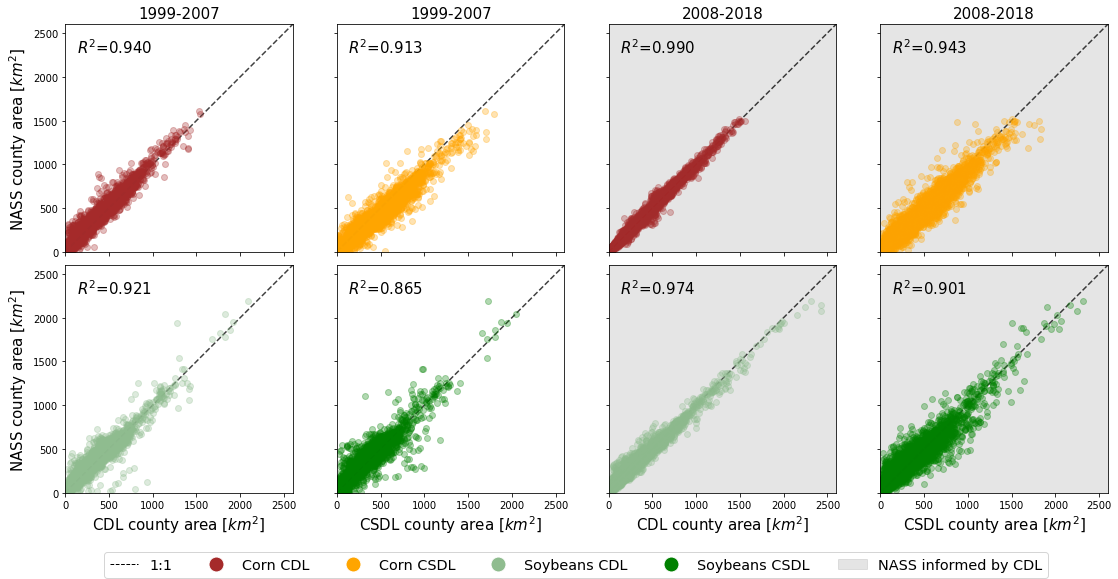

In [60]:
# Figure with Big R2 ( i.e the one calculated with sickit learn-machine learning- gove info on how far we are from 1:1 line)
# these R2 are lower.


# r2 = r2_score(df[col1].values, df[col2].values)
color_mapCSDL = { "Corn": 'orange',  "Soybeans": 'green'}
color_mapCDL = { "Corn": 'brown',  "Soybeans": 'darkseagreen'}
fsize = 15


lm = linear_model.LinearRegression()
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)


fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16,8))

for i,(id,group) in enumerate(df_sub[df_sub['year_group']=='1999-2007'].groupby(['crop'])):
           
            
    ax[i,0].scatter(group['CDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCDL[id], alpha=0.3, label=id)
    ax[i,1].scatter(group['CSDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCSDL[id], alpha=0.3, label=id)

    group1= group.dropna(subset=['CDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group1['CDL_Area_km2'].values,group1['Nass_Area_km2'].values)
    print(R2)
    ax[i,0].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,0].transAxes)

    group2= group.dropna(subset=['CSDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group2['CSDL_Area_km2'].values,group2['Nass_Area_km2'].values)
    print(R2)
    ax[i,1].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,1].transAxes)

    
    
#     lims = [0,2.6e+9] #area in m2
    lims = [0,2.6e+9/1e6]# km2
    # now plot both limits against each other
    ax[i,0].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,1].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,0].set_xlim(lims)
    ax[i,1].set_xlim(lims)
    ax[i,0].set_ylim(lims)
    ax[i,1].set_ylim(lims)  
    ax[i,0].set_aspect('equal')
    ax[i,1].set_aspect('equal')
#     ax[0,0].set_xticks(xlabels)
    ax[0,0].set_xticklabels('', rotation=90)
    ax[0,1].set_xticklabels('', rotation=90)
    ax[i,1].set_yticklabels('', rotation=90)


for i,(id,group) in enumerate(df_sub[df_sub['year_group']=='2008-2018'].groupby(['crop'])):

                   
    ax[i,2].scatter(group['CDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCDL[id], alpha=0.3, label=id)
    ax[i,3].scatter(group['CSDL_Area_km2'],group['Nass_Area_km2'], color = color_mapCSDL[id], alpha=0.3, label=id)
    
    # set background to gray and alpha=0.2
    ax[i,2].set_facecolor((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2))
    ax[i,3].set_facecolor((0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2))
    
    group1= group.dropna(subset=['CDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group1['CDL_Area_km2'].values, group1['Nass_Area_km2'].values)
    print(R2)
    ax[i,2].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,2].transAxes)

    
    group2= group.dropna(subset=['CSDL_Area_km2','Nass_Area_km2'])
    R2 = r2_score(group2['CSDL_Area_km2'].values,group2['Nass_Area_km2'].values)
    print(R2)
    ax[i,3].text(0.05, 0.9, '$R^2$={0:.3f}'.format(R2), ha="left", va="center", size=fsize, bbox=bbox_props, transform=ax[i,3].transAxes)

    
#     lims = [0,2.6e+9]
    lims = [0,2.6e+9/1e6]# area in km2
    # now plot both limits against each other
    ax[i,2].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,3].plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax[i,2].set_xlim(lims)
    ax[i,3].set_xlim(lims)
    ax[i,2].set_ylim(lims)
    ax[i,3].set_ylim(lims)    
    ax[i,2].set_aspect('equal')
    ax[i,3].set_aspect('equal')
    ax[0,2].set_xticklabels('', rotation=90)
    ax[0,3].set_xticklabels('', rotation=90)
    ax[i,2].set_yticklabels('', rotation=90)
    ax[i,3].set_yticklabels('', rotation=90)

ax[0,0].set_ylabel('NASS county area [$km^2$]',fontsize=fsize)    
ax[1,0].set_ylabel('NASS county area [$km^2$]',fontsize=fsize)   
ax[1,0].set_xlabel('CDL county area [$km^2$]',fontsize=fsize)
ax[1,1].set_xlabel('CSDL county area [$km^2$]',fontsize=fsize)
ax[1,2].set_xlabel('CDL county area [$km^2$]',fontsize=fsize)
ax[1,3].set_xlabel('CSDL county area [$km^2$]',fontsize=fsize)
ax[0,0].set_title('1999-2007',fontsize=fsize) 
ax[0,1].set_title('1999-2007',fontsize=fsize) 
ax[0,2].set_title('2008-2018',fontsize=fsize) 
ax[0,3].set_title('2008-2018',fontsize=fsize) 



# Create the legend
legend_elements = [ #Line2D([0], [0], color='b', linewidth=1, linestyle='-' , label='Fit'),
                    Line2D([0], [0], color='k', linewidth=1, linestyle='--', label='1:1'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='brown', markersize=15, label='Corn CDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=15, label='Corn CSDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkseagreen', markersize=15, label='Soybeans CDL'),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15, label='Soybeans CSDL'),
                    mpatches.Patch(facecolor='gray', edgecolor='gray', alpha = 0.2, label='NASS informed by CDL')
                  ]
# # legend on the right
# fig.legend(handles=legend_elements,
#            loc="lower right",   
#            bbox_to_anchor=(0.95, 0.3),
#            fontsize = 'x-large')
# legend on the bottom
fig.legend(handles=legend_elements,
           loc='lower center',  
           bbox_to_anchor=(0.5,-0.01),
           fontsize = 'x-large',
           ncol=7)


# fig.tight_layout(rect=[0,0,0.8,1]) # legend on the right
fig.tight_layout(rect=[0,0.05,1,1]) # legend on the bottom
fig.savefig(os.path.join(fig_repo,'Verification_PlantedArea_nassVsCSDLvsCDL_allyearsallStates_splitbyBA2008_removePartialCoverage95_R2.png'))#Before-After2008

In [61]:
df.head()

,fips,year,state,crop,Nass_Area_m2,COUNTYFP,STATEFP,CDL_perccov,CDL_Area_m2,CSDL_perccov,CSDL_Area_m2,Nass_Area_km2,CDL_Area_km2,CSDL_Area_km2,year_group
0,18007,2018,IN,Corn,485623200.0,7.0,18.0,100.0,4.546889e+08,99.998445,5.359128e+08,485.62320,454.688856,535.912815,2008-2018
1,18007,2017,IN,Corn,497763780.0,7.0,18.0,100.0,4.978370e+08,99.999416,4.926487e+08,497.76378,497.837007,492.648705,2008-2018
2,18007,2016,IN,Corn,505857500.0,7.0,18.0,100.0,4.867214e+08,99.986969,5.102580e+08,505.85750,486.721443,510.257982,2008-2018
3,18007,2015,IN,Corn,522044940.0,7.0,18.0,100.0,5.261466e+08,99.990275,5.378439e+08,522.04494,526.146558,537.843925,2008-2018
4,18007,2014,IN,Corn,526091800.0,7.0,18.0,100.0,5.104434e+08,99.997234,5.469219e+08,526.09180,510.443416,546.921904,2008-2018


In [62]:
totArea = df.groupby(['year','state','crop'])['Nass_Area_m2','CDL_Area_m2','CSDL_Area_m2'].sum().reset_index()
print(totArea.shape) #20years*13states*2commodity = 520 rows
totArea.head()

(520, 6)


,year,state,crop,Nass_Area_m2,CDL_Area_m2,CSDL_Area_m2
0,1999,IA,Corn,4.896701e+10,5.048426e+02,5.138523e+10
1,1999,IA,Soybeans,4.370609e+10,1.162953e+02,4.400934e+10
2,1999,IL,Corn,4.370609e+10,4.153363e+10,4.634802e+10
3,1999,IL,Soybeans,4.289672e+10,4.184464e+10,4.054591e+10
4,1999,IN,Corn,2.347179e+10,2.654150e+05,2.712819e+10


In [63]:
def corrfun(df,col1,col2):
    
    df = df.dropna(subset=[col2])
    
    if df.shape[0] != 0:
        r2 = r2_score(df[col1].values, df[col2].values)
        mse = mean_squared_error(df[col1].values, df[col2].values)
    else:
        r2 = np.nan
        mse = np.nan
        
    return pd.Series({'R':r2, 'mse':mse, 'Ncounties':df.shape[0]}) # return R2- coeff of determination

#     return pd.Series({'R':df[col1].corr(df[col2]), 'Ncounties':df.shape[0]}) # return Correlation coeff
    


In [50]:
corr_cdl = df[df['CDL_perccov']>90].groupby(['state','year','crop']).apply(corrfun,'Nass_Area_m2','CDL_Area_m2').reset_index().rename({'R':'R_NASS_CDL','mse':'mse_NASS_CDL','Ncounties':'Ncounties_CDL'},axis=1)
corr_cdl

,state,year,crop,R_NASS_CDL,mse_NASS_CDL,Ncounties_CDL
0,IA,2000,Corn,0.959916,1.840572e+15,84.0
1,IA,2000,Soybeans,0.929407,2.348138e+15,84.0
2,IA,2001,Corn,0.855639,6.123710e+15,99.0
3,IA,2001,Soybeans,0.750873,8.880001e+15,99.0
4,IA,2002,Corn,0.909704,3.533140e+15,99.0
...,...,...,...,...,...,...
405,WI,2016,Soybeans,0.955426,2.900737e+14,56.0
406,WI,2017,Corn,0.905020,2.571658e+15,55.0
407,WI,2017,Soybeans,0.966430,2.685860e+14,54.0
408,WI,2018,Corn,0.928172,1.978916e+15,51.0


In [51]:
corr_csdl = df.groupby(['state','year','crop']).apply(corrfun,'Nass_Area_m2','CSDL_Area_m2').reset_index().rename({'R':'R_NASS_CSDL','mse':'mse_NASS_CSDL','Ncounties':'Ncounties_CSDL'},axis=1)
corr_csdl

,state,year,crop,R_NASS_CSDL,mse_NASS_CSDL,Ncounties_CSDL
0,IA,1999,Corn,0.940656,2.393582e+15,99.0
1,IA,1999,Soybeans,0.971494,9.412537e+14,99.0
2,IA,2000,Corn,0.710090,1.191698e+16,99.0
3,IA,2000,Soybeans,0.806137,6.050472e+15,99.0
4,IA,2001,Corn,0.943532,2.395329e+15,99.0
...,...,...,...,...,...,...
515,WI,2016,Soybeans,0.701343,1.943586e+15,56.0
516,WI,2017,Corn,0.656229,9.307892e+15,55.0
517,WI,2017,Soybeans,0.755258,1.958115e+15,54.0
518,WI,2018,Corn,0.560187,1.211723e+16,51.0


In [52]:
corr = corr_cdl.merge(corr_csdl, on = ['state','year','crop'], how = 'outer')
print(corr.shape) #520x9
corr

(520, 9)


,state,year,crop,R_NASS_CDL,mse_NASS_CDL,Ncounties_CDL,R_NASS_CSDL,mse_NASS_CSDL,Ncounties_CSDL
0,IA,2000,Corn,0.959916,1.840572e+15,84.0,0.710090,1.191698e+16,99.0
1,IA,2000,Soybeans,0.929407,2.348138e+15,84.0,0.806137,6.050472e+15,99.0
2,IA,2001,Corn,0.855639,6.123710e+15,99.0,0.943532,2.395329e+15,99.0
3,IA,2001,Soybeans,0.750873,8.880001e+15,99.0,0.943753,2.004875e+15,99.0
4,IA,2002,Corn,0.909704,3.533140e+15,99.0,0.886696,4.433400e+15,99.0
...,...,...,...,...,...,...,...,...,...
515,WI,2000,Soybeans,NaN,NaN,NaN,0.852850,1.047923e+15,61.0
516,WI,2001,Corn,NaN,NaN,NaN,0.820112,4.126686e+15,63.0
517,WI,2001,Soybeans,NaN,NaN,NaN,0.839850,1.191930e+15,61.0
518,WI,2002,Corn,NaN,NaN,NaN,0.756964,6.312624e+15,63.0


In [53]:
corr = corr.merge(totArea, on=['state','year','crop'], how = 'left' )
print(corr.shape) #520x12
corr

(520, 12)


,state,year,crop,R_NASS_CDL,mse_NASS_CDL,Ncounties_CDL,R_NASS_CSDL,mse_NASS_CSDL,Ncounties_CSDL,Nass_Area_m2,CDL_Area_m2,CSDL_Area_m2
0,IA,2000,Corn,0.959916,1.840572e+15,84.0,0.710090,1.191698e+16,99.0,4.977638e+10,4.474088e+10,5.565037e+10
1,IA,2000,Soybeans,0.929407,2.348138e+15,84.0,0.806137,6.050472e+15,99.0,4.330140e+10,4.005790e+10,4.086934e+10
2,IA,2001,Corn,0.855639,6.123710e+15,99.0,0.943532,2.395329e+15,99.0,4.734826e+10,4.763744e+10,4.671164e+10
3,IA,2001,Soybeans,0.750873,8.880001e+15,99.0,0.943753,2.004875e+15,99.0,4.451546e+10,4.372346e+10,4.723863e+10
4,IA,2002,Corn,0.909704,3.533140e+15,99.0,0.886696,4.433400e+15,99.0,4.937169e+10,4.719149e+10,5.223038e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
515,WI,2000,Soybeans,NaN,NaN,NaN,0.852850,1.047923e+15,61.0,6.272633e+09,6.538352e+04,5.278325e+09
516,WI,2001,Corn,NaN,NaN,NaN,0.820112,4.126686e+15,63.0,1.375932e+10,2.927467e+05,1.457215e+10
517,WI,2001,Soybeans,NaN,NaN,NaN,0.839850,1.191930e+15,61.0,6.474976e+09,6.479193e+04,5.503514e+09
518,WI,2002,Corn,NaN,NaN,NaN,0.756964,6.312624e+15,63.0,1.477104e+10,1.149859e+05,1.771940e+10


In [54]:
abbr_to_state = {'IL':'Illinois', 'IA':'Iowa', 'IN':'Indiana', 'NE':'Nebraska', 'ND':'North Dakota',
                 'SD':'South Dakota', 'MN':'Minnesota', 'WI':'Wisconsin', 'MI':'Michigan',
                 'KS':'Kansas','KY':'Kentucky', 'OH':'Ohio', 'MO':'Missouri'}

corr['state_abbrs'] = corr['state']
corr["state_name"] = corr["state"].replace(abbr_to_state)
corr.head()

,state,year,crop,R_NASS_CDL,mse_NASS_CDL,Ncounties_CDL,R_NASS_CSDL,mse_NASS_CSDL,Ncounties_CSDL,Nass_Area_m2,CDL_Area_m2,CSDL_Area_m2,state_abbrs,state_name
0,IA,2000,Corn,0.959916,1.840572e+15,84.0,0.710090,1.191698e+16,99.0,4.977638e+10,4.474088e+10,5.565037e+10,IA,Iowa
1,IA,2000,Soybeans,0.929407,2.348138e+15,84.0,0.806137,6.050472e+15,99.0,4.330140e+10,4.005790e+10,4.086934e+10,IA,Iowa
2,IA,2001,Corn,0.855639,6.123710e+15,99.0,0.943532,2.395329e+15,99.0,4.734826e+10,4.763744e+10,4.671164e+10,IA,Iowa
3,IA,2001,Soybeans,0.750873,8.880001e+15,99.0,0.943753,2.004875e+15,99.0,4.451546e+10,4.372346e+10,4.723863e+10,IA,Iowa
4,IA,2002,Corn,0.909704,3.533140e+15,99.0,0.886696,4.433400e+15,99.0,4.937169e+10,4.719149e+10,5.223038e+10,IA,Iowa


In [55]:
# corr.to_csv(os.path.join(repo,'data','corrDF_verification_ts_plantedArea_nass_cdl_csdl_1999_2018.csv'),index=False)

In [56]:
# 13(states)*20(years)*2(crops)= 520 rows

In [57]:
state_geosorted = ['North Dakota','Minnesota', 'Wisconsin' ,'Michigan',
 'South Dakota','Iowa', 'Illinois', 'Indiana',
 'Nebraska', 'Missouri', 'Kentucky','Ohio',
 'Kansas']

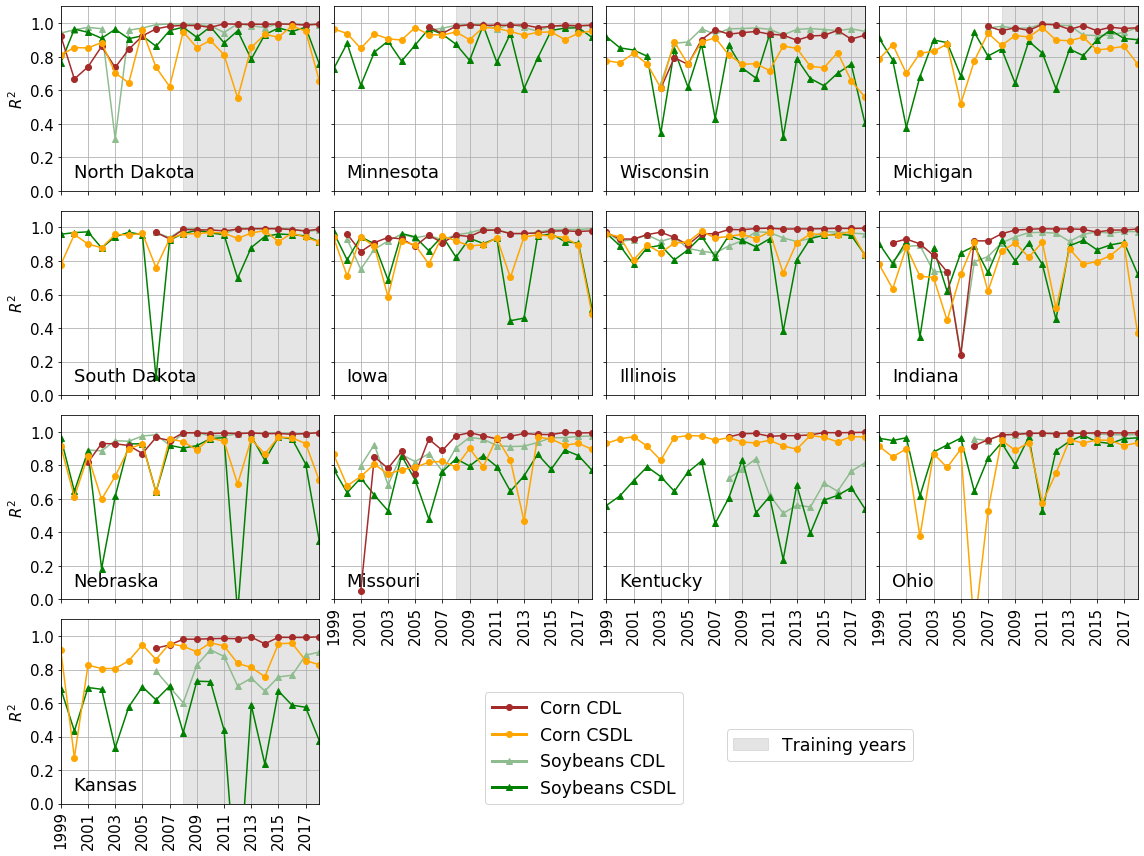

In [73]:
# Improve Figure: mod2 - spatial order
color_mapCSDL = { "Corn": 'orange',  "Soybeans": 'green'}
color_mapCDL = { "Corn": 'brown',  "Soybeans": 'darkseagreen'}
marker_map ={ "Corn": 'o',  "Soybeans": '^'}
fsize = 15
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.0)



fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(16,12))

for i, id in enumerate(state_geosorted):
    
    group = corr[corr['state_name']==id]

    thisAx = ax[int(np.floor(i/4)), i%4]
#     thisAx.set_title(id,fontsize=fsize)
    thisAx.text(0.05, 0.1, id, ha="left", va="center", size=18, bbox=bbox_props, transform=thisAx.transAxes)

    
    ylabels = np.arange(0, 12 ,2)/10
    thisAx.set_yticks(ylabels)
    thisAx.set_yticklabels('', rotation=0)
    
    xlabels = np.arange(1999, 2019,2)

    
    thisAx.set_xticks(xlabels)
    thisAx.set_xticklabels('', rotation=90)
    thisAx.fill_between(np.arange(2008, 2019), 0, 1.1, alpha = 0.2, color='gray')
    
#     for l,(id2,group2) in enumerate(group.groupby('crop')):
    crops = ['Soybeans','Corn']
    
    for l,id2 in enumerate(crops):
        group2 = group[group['crop']==id2]
        
#         print(id2)
        group2 = group2.sort_values('year')
        
        thisAx.plot(group2['year'],group2['R_NASS_CDL'],color=color_mapCDL[id2], alpha=1, marker=marker_map[id2])
        thisAx.plot(group2['year'],group2['R_NASS_CSDL'],color=color_mapCSDL[id2], alpha=1, marker=marker_map[id2])


    thisAx.set_xlim([1999,2018])
    thisAx.set_ylim([0.0, 1.1])
    thisAx.grid(True)
#     thisAx.legend(loc=4)

ax[0,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[1,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[2,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[3,0].set_ylabel('$R^{2}$',fontsize=fsize)
ax[0,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[1,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[2,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[3,0].set_yticklabels(ylabels, rotation=0,fontsize=fsize)
ax[3,0].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
# ax[2,1].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
# ax[2,2].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
# ax[2,3].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[-1,-1].axis('off')
ax[-1,-2].axis('off')
ax[-1,-3].axis('off')





# Create the legend
# colors = ['orange','green','brown','darkseagreen']
# lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
# # mylabels = ['Corn CDL', 'Corn CSDL', 'Soybeans CDL','Soybeans CSDL']
# mylabels = ['Soybeans CDL','Soybeans CSDL','Corn CDL', 'Corn CSDL']

# fig.legend(lines,     # The line objects
#            labels=mylabels,   # The labels for each line
#            loc="lower right",   # Position of legend
#            bbox_to_anchor=(0.6, 0.05),
#            fontsize = 'xx-large'
#            )

# Create the legend manually
legend_elements = [ Line2D([0], [0], color='brown',  linewidth=3, marker='o', linestyle='-', label='Corn CDL'),
                    Line2D([0], [0], color='orange',  linewidth=3, marker='o', linestyle='-', label='Corn CSDL'),
                    Line2D([0], [0], color='darkseagreen',  linewidth=3, marker='^', linestyle='-', label='Soybeans CDL'),
                    Line2D([0], [0], color='green',  linewidth=3, marker='^', linestyle='-', label='Soybeans CSDL'),
                  ]
fig.legend(handles=legend_elements,
           loc="lower right",   # Position of legend
           bbox_to_anchor=(0.6, 0.05),
           fontsize = 'xx-large'
            )




bckground_patch = mpatches.Patch(color='gray', alpha = 0.2, label='Training years')
fig.legend(handles=[bckground_patch],
           loc="lower right",
           bbox_to_anchor=(0.8, 0.1),
           fontsize = 'xx-large')


fig.tight_layout()  
ax[2,1].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[2,2].set_xticklabels(xlabels, rotation=90,fontsize=fsize)
ax[2,3].set_xticklabels(xlabels, rotation=90,fontsize=fsize)


fig.savefig(os.path.join(fig_repo,'Verification_Ts_R2_PlantedArea_nass_cdl_csdl.png'))